In [38]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import pickle

In [39]:
nba_data = pd.read_csv('Finalized_nba_data_for_modeling.csv', index_col = 0)

In [40]:
nba_data['TS%'] = [x/10 for x in nba_data['TS%']]

# turning TS% into the avergae for the team as it was originally the sum 

Applying all the interactions that were found to be the best from the multiple models

In [41]:
nba_data['TS_Ast'] = [nba_data['TS%'][i]*nba_data['AST%'][i] for i in range(len(nba_data['TS%']))]

In [42]:
nba_data['TS_ORB'] = [nba_data['TS%'][i]*nba_data['ORB%'][i] for i in range(len(nba_data['TS%']))]

In [43]:
nba_data['TS_Pts'] = [nba_data['TS%'][i]*nba_data['PTS'][i] for i in range(len(nba_data['TS%']))]

Removing the collinear and weak features found in the models

In [44]:
nba_data = nba_data.drop(columns = ['ORB%', '3PAr', 'FTr', 'AST%', '3P%', 'PTS', 'FT%'])

Creating Target and Features

In [45]:
target = nba_data['W']

In [46]:
features_list = []

In [47]:
for x in nba_data:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list.append(x)

In [48]:
features = nba_data[features_list]

Train Test Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=23,test_size=0.2)  

Applying Scalar (Standard Scalar) - Using it to get a better view of the data in the models and have a better idea of final results

In [50]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=features_list)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=features_list)

Lasso Test - Turned out to be the best type of model after comparing results in multiple scenarios

In [51]:
from sklearn.linear_model import Lasso

In [52]:
lasso = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

final_lasso = lasso.fit(X_train,y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_pred_lasso = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse))
print('Testing Error: '+ str(test_rmse))

Training Error: 5.793311083501199
Testing Error: 9.502349474112204


Viewing Lasso data as a graph

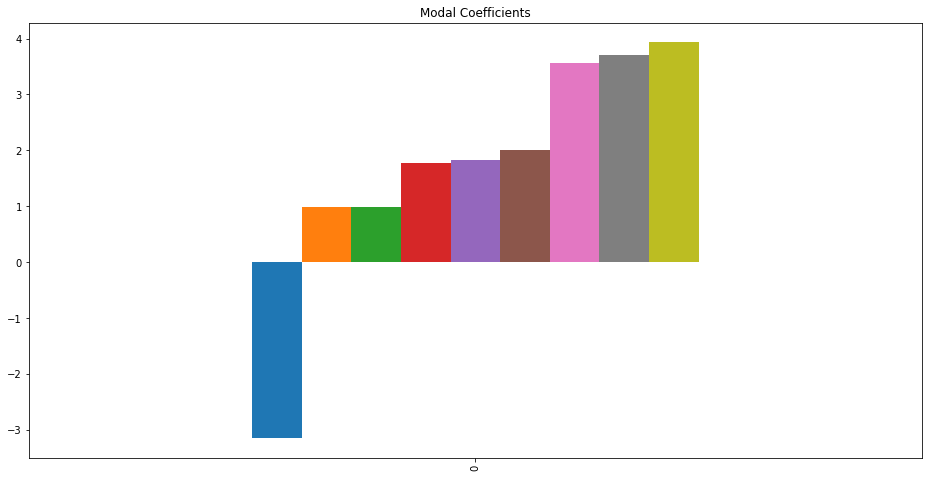

In [53]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [54]:
lasso_coef01.T

,0
TOV,-3.143905
BLK%,0.983185
TS_Ast,0.994133
TRB%,1.765074
STL%,1.826684
TS%,1.996904
Age,3.567495
TS_Pts,3.698365
TS_ORB,3.930379


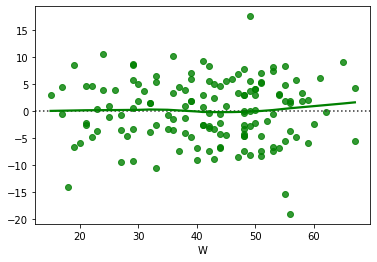

In [57]:
sns.residplot( y_train, y_train_pred_lasso,lowess=True, color="g")

Final Check of Collinearity of the Data

In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [56]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(5)

,VIF Factor,features
0,1.40838,Age
1,1.61052,TOV
2,3.84469,TS%
3,1.50570,TRB%
4,1.40607,STL%
5,1.31478,BLK%
6,1.58492,TS_Ast
7,1.32847,TS_ORB
8,3.21527,TS_Pts


Checking *R^2* Value

In [58]:
X_endog = sm.add_constant(X_test)

In [59]:
res = sm.OLS(list(y_test), X_endog)

In [60]:
res.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     7.171
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.62e-05
Time:                        20:52:23   Log-Likelihood:                -122.98
No. Observations:                  36   AIC:                             266.0
Df Residuals:                      26   BIC:                             281.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.9156      1.685     24.276      0.000      37.451      44.380
Age            5.9378      2.198      2.701      0.012       1.419      10.457
TOV           -2.5105      2.320     -1.082      0.289      -7.279       2.258
TS%            5.1021      2.836      1.799      0.084      -0.727      10.932
TRB%           2.1299      1.973      1.079      0.290      -1.926       6.186
STL%           1.1532      1.616      0.714      0.482      -2.168       4.475
BLK%           0.4069      1.433      0.284      0.779      -2.539       3.353
TS_Ast         2.9088      2.032      1.432      0.164      -1.268       7.085
TS_ORB         2.4973      1.872      1.334      0.194      -1.350       6.345
TS_Pts        -2.1722      2.210     -0.983      0.335      -6.714       2.370
==============================================================================
Omnibus:                        0.091   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.956   Jarque-Bera (JB):                0.029
Skew:                          -0.031   Prob(JB):                        0.986
Kurtosis:                       2.875   Cond. No.                         4.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The final model included 9 features the 4 most valuable, according to the Lasso model were,  Age, TS_Pts, TS_ORB and TOVs. 

Age was definitely a bit of a surprise. This value showed that things like maturity and leadership from older players might have more value to teams than other things.

TS_Pts and TS_ORB both made sense. As they show the efficiency of scoring with TS_Pts. TS_ORB is valuable because it means more possessions, if a team has a ton of offensive rebounds with more efficient shooting it means they can get a ton more possessions for a high powered offensive team.

TOV just like TS_ORB is a measure of possessions. This is negatively correlated as expected as less turnovers means you have the ball more. 

The model shows that NBA now has a high bias to offense. 4/6 highest influences in the model were offense based.  